# Import

In [142]:
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder

from sklearn.svm import SVC
from scipy.stats import expon, loguniform

# Data acquisition

In [10]:
# classifier >97% accuracy



IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='gray_r')
    plt.axis("off")

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

type(mnist)

sklearn.utils._bunch.Bunch

In [5]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
X, y = mnist["data"], mnist["target"]

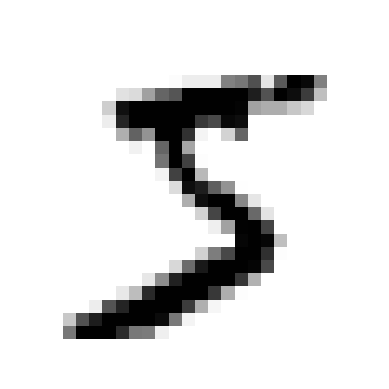

In [11]:
plot_digit(X[0])

# Lets initialize the pipeline

In [16]:
knn_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ('KNN_model',KNeighborsClassifier() )
    ])

In [15]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [17]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('KNN_model', KNeighborsClassifier())])

In [20]:
cross_val_score(knn_pipe, X_train, y_train , cv=3, scoring="accuracy")

array([0.9377 , 0.94125, 0.942  ])

In [23]:
param_grid = [{'KNN_model__n_neighbors': [1,3,4,5, 8],
               'KNN_model__weights': ['uniform', 'distance'] 
            }]

In [24]:
gcf = GridSearchCV(knn_pipe, param_grid, cv=3, scoring='accuracy')

In [25]:
gcf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('KNN_model', KNeighborsClassifier())]),
             param_grid=[{'KNN_model__n_neighbors': [1, 3, 4, 5, 8],
                          'KNN_model__weights': ['uniform', 'distance']}],
             scoring='accuracy')

In [26]:
gcf.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('KNN_model',
                 KNeighborsClassifier(n_neighbors=4, weights='distance'))])

In [27]:
gcf.best_score_

0.9439333333333334

In [58]:
param_grid = [{'rfc__n_estimators': np.arange(1,200, 10), 'rfc__max_depth':np.arange(40,80,1),'rfc__min_samples_leaf': 
[1,2,4],'rfc__max_features':[1,2,3,4,5,6,7,8]
            }]

In [59]:
rfc_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ('rfc', RandomForestClassifier() )
    ])

rrfc = RandomizedSearchCV(rfc_pipe, param_grid, cv=3, scoring='accuracy', n_jobs=-1, n_iter=10)

In [60]:
rrfc.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('rfc',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions=[{'rfc__max_depth': array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
       74, 75, 76, 77, 78, 79]),
                                         'rfc__max_features': [1, 2, 3, 4, 5, 6,
                                                               7, 8],
                                         'rfc__min_samples_leaf': [1, 2, 4],
                                         'rfc__n_estimators': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
       131, 141, 151, 161, 171, 181, 191])}],
                   scoring='accuracy')

In [61]:
rrfc.best_score_

0.9629499999999999

In [62]:
rrfc.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(max_depth=56, max_features=8,
                                        n_estimators=191))])

# Titanic investigation

In [63]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

In [64]:
train_data, test_data = load_titanic_data()

### Useful vars:
* survived (=target) - binary
* pcclass - ordinal
* sex - binary
* age - numeric
* sibsp - ordinal
* parch - ordinal
* Fare - numeric
* embarked - categorical

In [65]:
train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [66]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* we need for age inputation cabin is not important embarked also 

In [67]:
X_train = train_data.drop(['Survived', 'Name', 'Ticket', 'Cabin'], axis =1)

In [68]:
X_train.set_index('PassengerId', inplace=True)

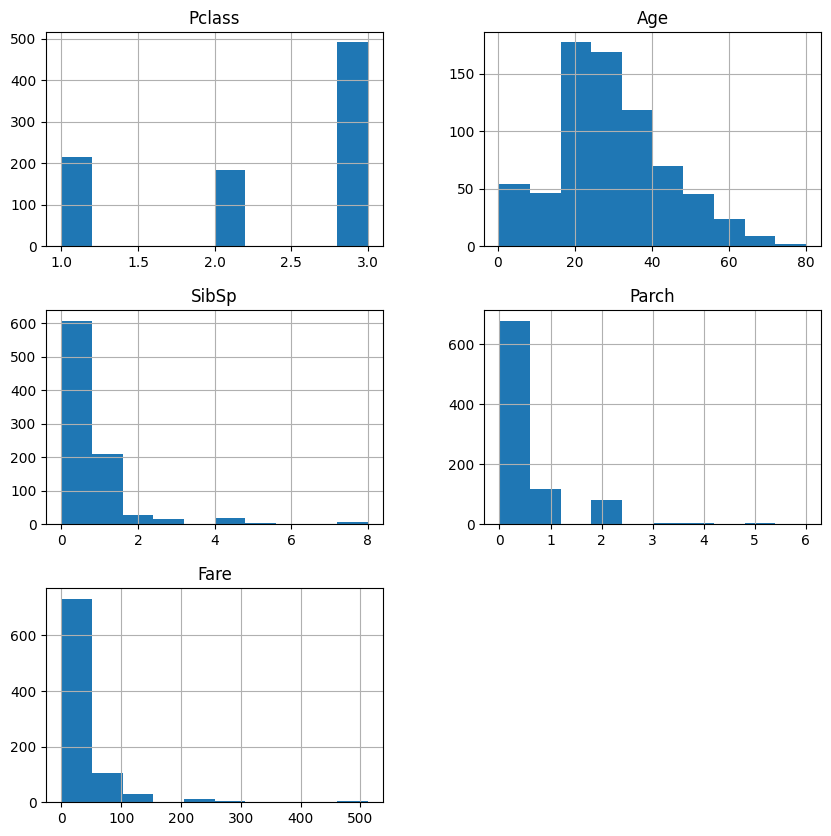

In [70]:
numeric_cols = X_train.select_dtypes(include=np.number).columns
X_train[numeric_cols].hist(figsize=(10, 10))
plt.show()


In [97]:
# define pipes

def int_trans(x):
    return x.astype(int)

def age_pipe():
    return make_pipeline(
        KNNImputer(),
        FunctionTransformer(int_trans, feature_names_out='one-to-one'),
        StandardScaler()
    )
def cat_pipe():
    return make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(handle_unknown ='ignore')
    )

def num_pipe():
    return make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        StandardScaler()
    )

pandas.core.frame.DataFrame

In [109]:
trans = ColumnTransformer([
        ("trans", age_pipe(), ["Age"]),
        ("cat", cat_pipe(), make_column_selector(dtype_include=object))
        ],
    remainder=num_pipe())

In [111]:

X_trans = pd.DataFrame(trans.fit_transform(X_train), columns= trans.get_feature_names_out())

In [112]:
X_trans.head()


,trans__Age,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S,remainder__Pclass,remainder__SibSp,remainder__Parch,remainder__Fare
0,-0.580044,0.0,1.0,0.0,0.0,1.0,0.827377,0.432793,-0.473674,-0.502445
1,0.650112,1.0,0.0,1.0,0.0,0.0,-1.566107,0.432793,-0.473674,0.786845
2,-0.272505,1.0,0.0,0.0,0.0,1.0,0.827377,-0.474545,-0.473674,-0.488854
3,0.419458,1.0,0.0,0.0,0.0,1.0,-1.566107,0.432793,-0.473674,0.420730
4,0.419458,0.0,1.0,0.0,0.0,1.0,0.827377,-0.474545,-0.473674,-0.486337


In [143]:
knn_pipe = Pipeline([('transfo', trans),
                ('knn',KNeighborsClassifier())
])

svc_pipe = Pipeline([('transfo', trans),
                ('svc',SVC())])

In [122]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('transfo',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='most_frequent')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('trans',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function int_trans at 0x0000023071A9B100>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000023071B62ED0>)])),
                ('knn', KNeighborsClassifier(n_neighbors=4))])

In [124]:
cross_val_score(knn_pipe, X_train, y_train, cv=5, scoring='accuracy')

array([0.77653631, 0.75280899, 0.82022472, 0.82022472, 0.78651685])

In [131]:
param_grid = [{'knn__n_neighbors': np.arange(1,10),
               'knn__weights': ['uniform', 'distance'] 
            }]

In [133]:
grid_search = GridSearchCV(knn_pipe, param_grid, cv=5,
                           scoring='accuracy')

In [134]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transfo',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='most_frequent')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('trans',
                                                                         Pipeline(steps=[('knnimputer',
                                                                                          KNNImputer()),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<function...
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000023071B62ED0>)])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid=[{'knn__n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                          'knn__weights': ['uniform', 'distance']}],
             scoring='accuracy')

In [139]:
grid_search.best_params_

{'knn__n_neighbors': 5, 'knn__weights': 'uniform'}

In [140]:
grid_search.best_score_

0.810344611135522

In [144]:
param_distribs = {
        'svc__kernel': ['linear', 'rbf', 'poly'],
        'svc__C': loguniform(20, 200_000),
        'svc__gamma': expon(scale=1.0),
    }

In [145]:
svc_pipe.fit(X_train, y_train)

Pipeline(steps=[('transfo',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='most_frequent')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('trans',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function int_trans at 0x0000023071A9B100>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000023071B62ED0>)])),
                ('svc', SVC())])

In [146]:
rnd_search = RandomizedSearchCV(svc_pipe,
                                param_distributions=param_distribs,
                                n_iter=50, cv=3,
                                scoring='accuracy',
                                random_state=42)

In [ ]:
rnd_search.fit(X_train, y_train)